## This notebook works on Word Embeddings using Keras (Fine tune learned embeddings)

## This uses the Word2Vec Model

### Import the libraries and define the arguments

In [3]:
# import the necessary libraries
from keras.layers.core import Dense, Activation, Dropout, SpatialDropout1D 
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

# adding the import from gensim implementation of word2vec
from gensim.models import word2vec
from gensim.models import KeyedVectors

import nltk
import collections
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
%matplotlib inline

np.random.seed(42)

INPUT_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt"
WORD2VEC_WEIGHTS = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/google_news_word2vec/GoogleNews-vectors-negative300.bin"
VOCAB_SIZE = 5000
EMBEDDING_SIZE = 300
NUM_FILTERS=256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10    # reduced the number of epochs to 10 as convergence is reached on using pre-trained weights
DROPOUT_RATE = float(0.2)

Using Theano backend.


### Learn Embeddings using Fine Tuning pre-trained weights

In [4]:
# create our vocablary of most frequent words from the corpus
counter = collections.Counter()
fin = open(INPUT_FILE, 'r')
maxlen = 0
i = 0
for line in fin:
    sent = line.strip().split("\t")[1]
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1
fin.close()

# create the word indexes and the reverse indexes for the words
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid +1
vocab_size = len(word2index) + 1
index2word = {v:k for k,v in word2index.items()}
print(len(word2index))
print("")
print(word2index)
# print(index2word)

2329

defaultdict(<class 'int'>, {'hill-form': 969, 'same': 161, 'crack': 972, 'fire.-i': 974, 'raises': 1431, 'mary': 976, 'tree': 977, '6': 978, "'ve": 357, 'itself': 980, '10.9': 981, 'group': 982, 'news': 448, 'whatev': 983, 'soooo': 970, 'trivia': 985, 'mcmurtry': 986, 'school': 416, 'tomorrow': 987, 'preview': 1672, 'how': 72, 'blows': 990, 'looks': 386, 'colourfully': 648, 'writes': 991, 'around': 183, 'literary': 2112, 'linked': 992, 'am': 57, 'quiz': 227, '1984': 993, 'fanfic': 650, 'rides': 994, 'halfway': 995, 'often': 651, 'mocking..': 1105, 'till': 652, 'mountain': 12, 'mountain-which': 998, 'amazing..': 999, 'turner': 1000, 'such': 142, 'that': 26, 'u': 653, 'â™': 654, 'quaintly': 1002, 'christain': 1003, 'compared': 655, 'rules': 1004, 'suppose': 656, 'goin': 228, 'be': 45, 'smoking-had': 1993, 'm': 536, 'comprehend': 1005, 'admiring': 1006, 'awesome..': 129, 'much..': 417, 'requim': 1007, 'was': 18, 'deserved': 657, 'dragons': 723, 'latest': 1679, 'decomposing': 1892, '

### Now pad the sentences to the maxlength and create the dataset for splitting

In [11]:
xs , ys = [], []
fin = open(INPUT_FILE, "r")

# there are 7086 sentences in the train set , each of those sentences are tokenized and the word2vec is generated
# for each of the token, and label is the label for the sentence
for line in fin:
    label, sent = line.strip().split("\t") 
    ys.append(int(label))
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X = pad_sequences(xs, maxlen=maxlen)
Y = np_utils.to_categorical(ys)

### Split the X and y to train and validation set using sklearn 

In [6]:
#print(maxlen) # 42 in this case
# print(X.shape) # (7086 , 42) is the shape
# print(Y.shape)  # (7086, 2) is the shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4960, 42)
(2126, 42)
(4960, 2)
(2126, 2)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   7,  13,  16,  21,   1, 107,  65, 193,  73, 176, 173,
       260,   6,  91], dtype=int32)

### Load the word2vec model trained weights

In [28]:
#load word2vec model
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_WEIGHTS, binary=True)
embedding_weights = np.zeros((vocab_size, EMBEDDING_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index:] = word2vec[word]
    except KeyError:
        pass

### Now define the model and compile the model and fit the model on the train data

In [29]:
embedding_weights.shape

(2330, 300)

In [32]:
model = Sequential()
# the difference is to initialize the embedding weight matrix with pretrained weights
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=maxlen, weights=[embedding_weights]))  
model.add(SpatialDropout1D(DROPOUT_RATE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 42, 300)           699000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 42, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 256)           230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 930,170
Trainable params: 930,170
Non-trainable params: 0
_________________________________________________________________


In [33]:
# have the model compile and fit on the training data

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))

Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 8s - loss: 0.2680 - acc: 0.8919 - val_loss: 0.0644 - val_acc: 0.9779
Epoch 2/20
4960/4960 [==============================] - 8s - loss: 0.0375 - acc: 0.9869 - val_loss: 0.0346 - val_acc: 0.9845
Epoch 3/20
4960/4960 [==============================] - 8s - loss: 0.0152 - acc: 0.9948 - val_loss: 0.0382 - val_acc: 0.9840
Epoch 4/20
4960/4960 [==============================] - 8s - loss: 0.0063 - acc: 0.9978 - val_loss: 0.0329 - val_acc: 0.9887
Epoch 5/20
4960/4960 [==============================] - 8s - loss: 0.0032 - acc: 0.9988 - val_loss: 0.0299 - val_acc: 0.9887
Epoch 6/20
4960/4960 [==============================] - 8s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0299 - val_acc: 0.9878
Epoch 7/20
4960/4960 [==============================] - 8s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0279 - val_acc: 0.9911
Epoch 8/20
4960/4960 [==============================] - 9s - loss: 0.0016 - a

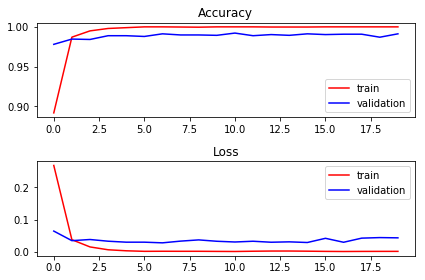

In [35]:
#plot loss function

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [36]:
# check the accuracy and the loss on the test set
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

2080/2126 [============================>.] - ETA: 0s[0.043363538133573083, 0.99106302916274691]
